In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tqdm import tqdm
import ast 

import pandas as pd
import json

from collections import defaultdict, Counter
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import stats
from scipy import interpolate


In [8]:
cd /content/drive/MyDrive/ADA_Proj

/content/drive/MyDrive/ADA_Proj


# Task 5: Occupation Bias

## Context

In order to get a better insight about bitcoin sentiment, we thought of different ways of aggregating data.<br>
One of the most relevant ones seemed to be Occupation, so let's try to see if there's a sentiment bias due to occupation.

## Analysis

Given the noisiness of the data, we use bootstrapping to estimate results as good as possible.

In [4]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        # data_tmp is sampled by sampling with replacement
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [9]:
# Read data obtained from the 1st step
speakers = pd.read_csv("./M3/Data/speakers.csv")
speakers = speakers.set_index('id')

# Convert string to list
speakers['fields'] = speakers['fields'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else None)
speakers['occupations'] = speakers['occupations'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else None)

In [11]:
# Read data obtained from the 2nd step
quotes = pd.read_csv("./M3/Data/bitcoin_data_with_sentiment_final.csv")
len(quotes)

20109

In [12]:
# Extract time data
quotes['year'] = pd.to_datetime(quotes['date']).dt.to_period('Y')
quotes['month'] = pd.to_datetime(quotes['date']).dt.to_period('M')
quotes['date'] = pd.to_datetime(quotes['date']).dt.to_period('D')
# The score is in range [-1,1], we use threshold 0 to assign positive or negative label for each quotation
quotes['sentiment'] = quotes['score'].apply(lambda x: 'positive' if x>=0 else 'negative')

In [13]:
# Convert string to list of qids
quotes['qids'] = quotes['qids'].apply(ast.literal_eval)
# Remove speakers having multiple qids (we don't know exactly who they are)
cleaned_quotes = quotes[quotes['qids'].apply(lambda x : len(x)==1)]
cleaned_quotes['qids'] = cleaned_quotes['qids'].apply(lambda x: x[0])
len(cleaned_quotes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


8810

# Who speak most?

As there are too many speakers, we won't analyze the behaviour of each individual, especially since most people have no more than 10 quotes, which is not even near to get good classification results.<br>
Thus we'll first concentrate on people who speak the most to get some insight before speaking about the occupation.

In [96]:
# Aggregate total number of quotation by speakers
qid_to_score_and_freq = cleaned_quotes.groupby('qids',as_index=False).agg({"score":"mean","quotation":"count", "year":pd.Series.nunique})
# Merge to get information of speakers
speaker_to_score_and_freq = qid_to_score_and_freq.merge(speakers, left_on='qids', right_index=True)
# Top 20 speakers by their number of quotations
top_speakers = speaker_to_score_and_freq.nlargest(20,['quotation']).sort_values(by='quotation', ascending=False)
# Get their ids
top_speaker_ids = top_speakers['qids'].tolist()
top_speakers

,qids,score,quotation,year,label,year_of_birth,Gender,nationalities,occupations,fields
1974,Q922169,-0.336372,194,5,Jamie Dimon,1956.0,male,['United States of America'],[banker],"[Business, management and administration]"
377,Q19600251,0.108761,184,6,Roger Ver,1979.0,male,"['United States of America', 'Saint Kitts and ...",[entrepreneur],"[Business, management and administration]"
1911,Q7807093,0.294392,161,6,Timothy C. Draper,1958.0,male,['United States of America'],[businessperson],"[Business, management and administration]"
811,Q335552,0.277497,146,5,Jack Dorsey,1976.0,male,['United States of America'],"[blogger, entrepreneur, chief executive office...","[Science and technology, Business, management ..."
332,Q18352176,0.025524,111,6,Andreas Antonopoulos,1972.0,male,"['Greece', 'United Kingdom']","[technologist, writer, motivational speaker]","[Science and technology, Communications]"
1024,Q45864,0.098369,102,6,John McAfee,1945.0,male,['United States of America'],"[engineer, computer scientist, businessperson,...","[Government, Business, management and administ..."
759,Q3066193,0.140187,97,6,Tyler Winklevoss,1981.0,male,['United States of America'],"[entrepreneur, computer scientist, rower]","[Sport, Business, management and administratio..."
2011,Q983539,0.232173,93,6,Max Keiser,1960.0,male,['United States of America'],"[reporter, banker, film producer, journalist, ...","[Arts, culture and entertainment, Business, ma..."
776,Q313923,-0.426480,88,4,Nouriel Roubini,1958.0,male,['United States of America'],"[economist, university teacher, art collector]","[Arts, culture and entertainment, Business, ma..."
760,Q3066455,0.275852,87,5,Cameron Winklevoss,1981.0,male,['United States of America'],"[entrepreneur, computer scientist, rower]","[Sport, Business, management and administratio..."


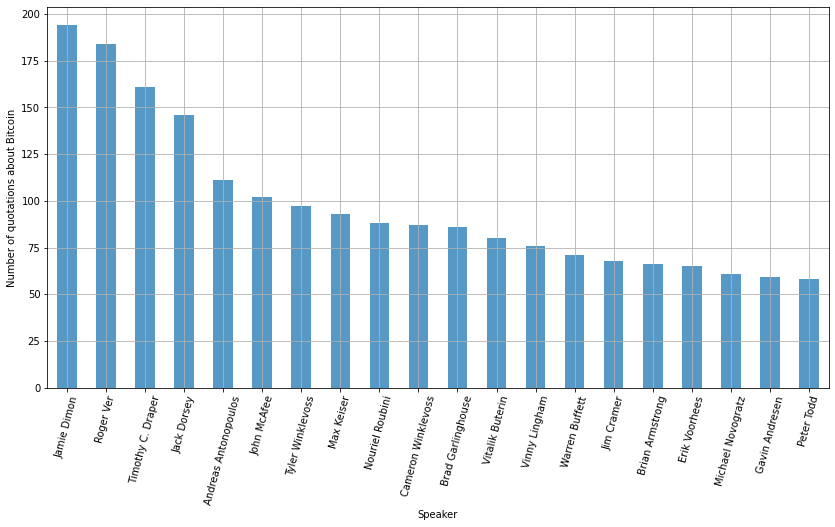

In [99]:
distribution_speakers = top_speakers[['quotation','label']].set_index(['label'])
distribution_speakers.plot(kind='bar', figsize=(14,7), grid=True, legend=False, xlabel='Speaker', ylabel='Number of quotations about Bitcoin',alpha=0.75, rot=75)

In [101]:
top_speakers[['label','occupations', 'fields']]

,label,occupations,fields
1974,Jamie Dimon,[banker],"[Business, management and administration]"
377,Roger Ver,[entrepreneur],"[Business, management and administration]"
1911,Timothy C. Draper,[businessperson],"[Business, management and administration]"
811,Jack Dorsey,"[blogger, entrepreneur, chief executive office...","[Science and technology, Business, management ..."
332,Andreas Antonopoulos,"[technologist, writer, motivational speaker]","[Science and technology, Communications]"
1024,John McAfee,"[engineer, computer scientist, businessperson,...","[Government, Business, management and administ..."
759,Tyler Winklevoss,"[entrepreneur, computer scientist, rower]","[Sport, Business, management and administratio..."
2011,Max Keiser,"[reporter, banker, film producer, journalist, ...","[Arts, culture and entertainment, Business, ma..."
776,Nouriel Roubini,"[economist, university teacher, art collector]","[Arts, culture and entertainment, Business, ma..."
760,Cameron Winklevoss,"[entrepreneur, computer scientist, rower]","[Sport, Business, management and administratio..."


Then we keep only the quotations of these speakers, which will be our focus in the analysis.

In [41]:
# Keep only quotations of top speakers
top_speaker_quotes = cleaned_quotes[cleaned_quotes['qids'].isin(top_speaker_ids)]
# Calculate the mean and confidence interval for sentiment scores
stats_by_year = top_speaker_quotes.groupby(['qids', 'year'], as_index=False).apply(lambda x: pd.Series({
        'average_score': x['score'].mean(),
        'lower_err_score': bootstrap_CI(x['score'], 1000)[0],
        'upper_err_score': bootstrap_CI(x['score'], 1000)[1]
    }))
stats_by_year['year'] = stats_by_year['year'].apply(lambda x: int(str(x)))
stats_by_year

,qids,year,average_score,lower_err_score,upper_err_score
0,Q16197959,2015,-0.074489,-0.259975,0.104181
1,Q16197959,2016,-0.012498,-0.126048,0.132272
2,Q16197959,2017,0.027387,-0.091370,0.148889
3,Q16197959,2018,-0.146763,-0.308465,0.009644
4,Q16197959,2019,-0.011693,-0.118535,0.118945
...,...,...,...,...,...
97,Q983539,2016,0.437906,0.350909,0.524903
98,Q983539,2017,0.148901,0.035754,0.253571
99,Q983539,2018,0.102648,-0.266299,0.400986
100,Q983539,2019,0.285711,0.205339,0.360535


Finally, here are the sentiments change over time of the people that we chose, along with the possible error given by the confidence interval.

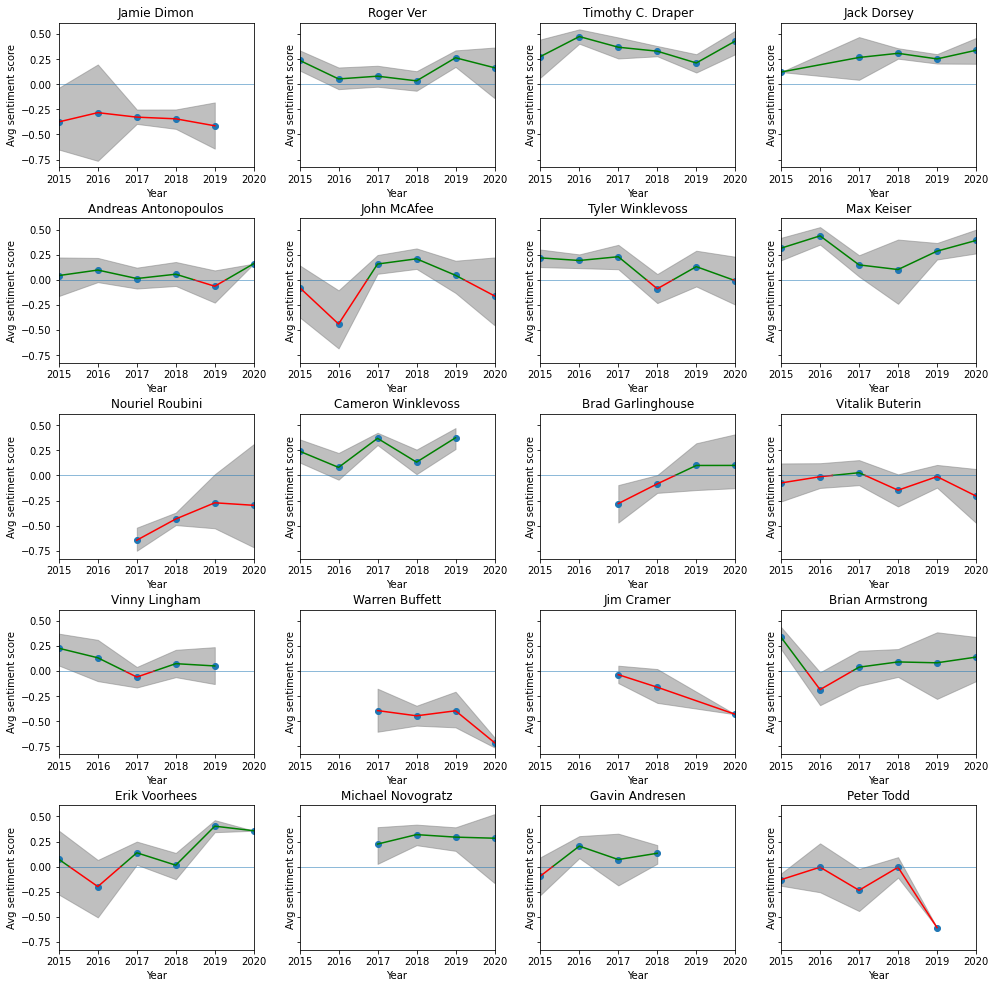

In [25]:
def insert_between_points(t, x, zero=0):
    ta = []
    positive = (x-zero) > 0
    ti = np.where(np.bitwise_xor(positive[1:], positive[:-1]))[0]
    for i in ti:
        y_ = np.sort(x[i:i+2])
        z_ = t[i:i+2][np.argsort(x[i:i+2])]
        t_ = np.interp(zero, y_, z_)
        ta.append( t_ )
    tnew = np.append( t, np.array(ta) )
    xnew = np.append( x, np.ones(len(ta))*zero )
    xnew = xnew[tnew.argsort()]
    tnew = np.sort(tnew)
    return tnew, xnew

fig, axs = plt.subplots(5,4, sharey=True, figsize=(14,14))
fig.tight_layout(pad=3.0)
axs = axs.flatten()
for i, top_speaker_id in enumerate(top_speaker_ids):
    # Get data for a single speaker
    stats_by_year_speaker = stats_by_year[stats_by_year['qids']==top_speaker_id]
    
    # Fill confidence intervals by gray
    axs[i].fill_between(stats_by_year_speaker.year.values, stats_by_year_speaker.lower_err_score.values,
                     stats_by_year_speaker.upper_err_score.values, alpha = 0.5, color = 'gray')

    year_new, score_new = insert_between_points(stats_by_year_speaker.year.values, stats_by_year_speaker.average_score.values)

    pos_signal = score_new.copy()
    neg_signal = score_new.copy()

    pos_signal[pos_signal < 0] = np.nan
    neg_signal[neg_signal > 0] = np.nan

    #plotting        
    axs[i].plot(year_new, pos_signal, color='g')
    axs[i].plot(year_new, neg_signal, color='r')

    axs[i].scatter(stats_by_year_speaker.year.values, stats_by_year_speaker.average_score.values)

    axs[i].axhline(y=0, linewidth=0.5)
    axs[i].set_ylabel("Avg sentiment score")
    axs[i].set_xlabel("Year")
    axs[i].set_title(speakers.loc[top_speaker_id].label)
    axs[i].set_xlim([2015, 2020])

# See the distribution by year

Now we move on to the occupation bias analysis.

In [16]:
def sample_mean(data):
    data = data.values
    indices = np.random.randint(0, len(data), len(data))
    data_tmp = data[indices] 
    return np.nanmean(data_tmp)

In [17]:
new_rows = []
for idx, year in enumerate(range(2015,2021)):
    # We run 1000 times
    for _ in tqdm(range(1000), desc="Sample in "+str(year)):
        sentiment_count = {}
        # Get quotation in this year
        cleaned_quotes_by_year = cleaned_quotes[cleaned_quotes['year']==str(year)]
        
        # Sample the mean of sentiment score for each speakers
        qid_to_score_by_year = cleaned_quotes_by_year.groupby('qids',as_index=False).agg({"score":sample_mean})
        
        # Merge to get speaker information
        speaker_to_score_by_year = qid_to_score_by_year.merge(speakers, left_on='qids', right_index=True)
        
        # Assign label for each speakers
        speaker_to_score_by_year['sentiment'] = speaker_to_score_by_year['score'].apply(lambda x: 'positive' if x>=0 else 'negative')
        
        # Since we need fields information, we drop nan values
        speaker_to_score_by_year = speaker_to_score_by_year.dropna(subset=['fields'])
        
        # Count the number of positive/negative speaker in each fields
        for i in range(len(speaker_to_score_by_year)):
            # The fields of each speakers is a list, so value of one speaker can contribute to multiple fields
            for field in speaker_to_score_by_year['fields'].iloc[i]:
                sentiment_count[(year,field, speaker_to_score_by_year['sentiment'].iloc[i])] = sentiment_count.get((year,field, speaker_to_score_by_year['sentiment'].iloc[i]),0) + 1
                
        for k,v in sentiment_count.items():
            new_rows.append([k[0],k[1],k[2],v])
sentiment_fields_year = pd.DataFrame(new_rows, columns=['year', 'fields','sentiment','count'])
# Each triplet ('year', 'field','sentiment') will have 1000 values of count since we sample 1000 times
sentiment_fields_year

Sample in 2020: 100%|██████████| 1000/1000 [00:29<00:00, 33.99it/s]


,year,fields,sentiment,count
0,2015,Law and public policy,negative,9
1,2015,Sport,negative,14
2,2015,Government,negative,17
3,2015,"Arts, culture and entertainment",positive,42
4,2015,Government,positive,21
...,...,...,...,...
129351,2020,Community and social services,negative,2
129352,2020,Communications,negative,12
129353,2020,Education,negative,4
129354,2020,Architecture and engineering,positive,1


In [28]:
stats_by_year = sentiment_fields_year.groupby(['year', 'fields','sentiment'], as_index=False).apply(lambda x: pd.Series({
        'average_count': x['count'].mean(),
        'lower_err_count': x['count'].mean() - np.nanpercentile(x['count'], 2.5),
        'upper_err_count': np.nanpercentile(x['count'], 97.5) - x['count'].mean()
    }))
stats_by_year['year'] = stats_by_year['year'].apply(lambda x: int(str(x)))
stats_by_year

,year,fields,sentiment,average_count,lower_err_count,upper_err_count
0,2015,Architecture and engineering,negative,2.242,0.242,0.758
1,2015,Architecture and engineering,positive,1.000,0.000,0.000
2,2015,"Arts, culture and entertainment",negative,14.838,1.838,2.162
3,2015,"Arts, culture and entertainment",positive,40.162,2.162,1.838
4,2015,"Business, management and administration",negative,29.965,2.965,3.035
...,...,...,...,...,...,...
126,2020,Law and public policy,positive,7.768,0.768,0.232
127,2020,Science and technology,negative,13.575,2.575,2.425
128,2020,Science and technology,positive,16.425,2.425,2.575
129,2020,Sport,negative,2.553,0.553,0.447


In [19]:
# Some fields have small number of occurence, so we remove them
SELECTED_FIELDS = sorted(['Communications', 'Sport', 'Education', 'Science and technology', 'Business, management and administration','Arts, culture and entertainment','Government', 'Law and public policy'])

First we plot the sentiment by year by occupation.

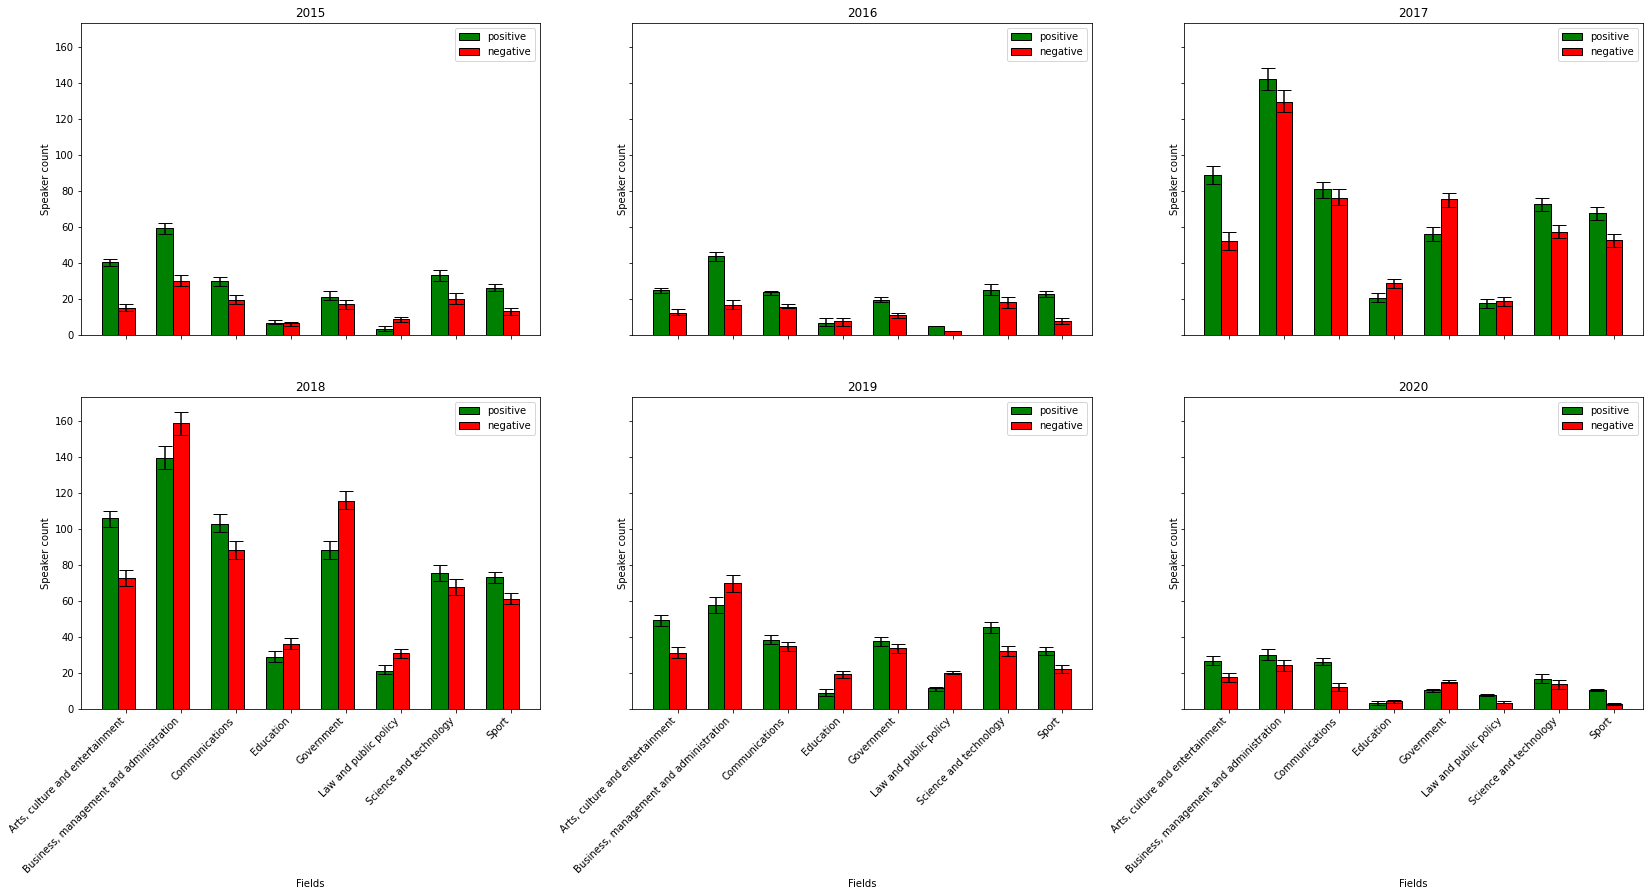

In [29]:
fig, axs = plt.subplots(2,3, sharey=True, figsize=(28,14))
axs = axs.flatten()
for i, year in enumerate(range(2015,2021)):
    stats_by_one_year = stats_by_year[(stats_by_year['year']==year)&(stats_by_year['fields'].isin(SELECTED_FIELDS))].sort_values(by=['fields','sentiment'])
                                                                                                                                    
    barWidth = 0.3
    pos_bars = stats_by_one_year[stats_by_one_year.sentiment=='positive'].average_count.values
    neg_bars = stats_by_one_year[stats_by_one_year.sentiment=='negative'].average_count.values
    pos_yer = stats_by_one_year[stats_by_one_year.sentiment=='positive'][['lower_err_count', 'upper_err_count']].values.T
    neg_yer = stats_by_one_year[stats_by_one_year.sentiment=='negative'][['lower_err_count', 'upper_err_count']].values.T

    r1 = np.arange(len(pos_bars))
    r2 = [x + barWidth for x in r1]
 
    axs[i].bar(r1, pos_bars, width = barWidth, color = 'g', edgecolor = 'black', yerr=pos_yer, capsize=7, label='positive')
    axs[i].bar(r2, neg_bars, width = barWidth, color = 'r', edgecolor = 'black', yerr=neg_yer, capsize=7, label='negative')
    axs[i].set_xticks([r + barWidth for r in range(len(pos_bars))])
    axs[i].set_xticklabels(SELECTED_FIELDS, rotation=45, ha='right')
    # axs[i].set_xticklabels(SELECTED_FIELDS)
    axs[i].set_ylabel('Speaker count')
    axs[i].set_xlabel('Fields')
    axs[i].legend()
    axs[i].set_title(year)
fig.autofmt_xdate(rotation=45)


Then we plot the sentiment before 2017 and after 2017 for each occupation.

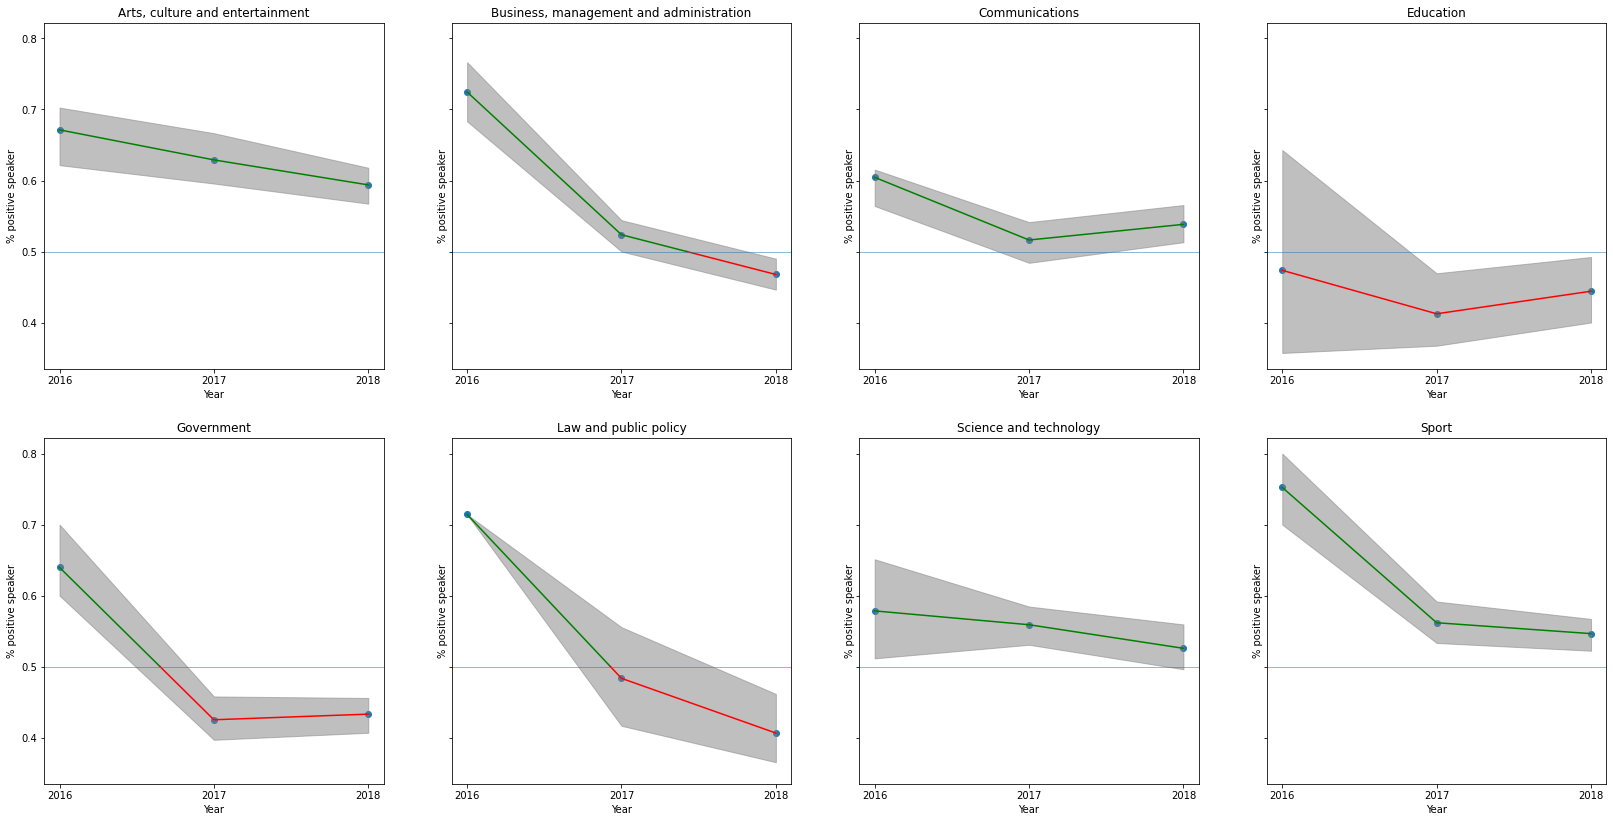

In [30]:
fig, axes = plt.subplots(2,4,sharey=True, figsize=(28,14))
axes= axes.flatten()
years = np.array(range(2016,2019))
for i, field in enumerate(SELECTED_FIELDS):
    lowers = []
    uppers = []
    means = []
    for idx, year in enumerate(years):
        # Get quotation in this year
        cleaned_quotes_by_year = cleaned_quotes[cleaned_quotes['year']==str(year)]
        
        # Calculate the mean of sentiment score for each speakers, but we don't use it, just to make the qids unique
        qid_to_score_by_year = cleaned_quotes_by_year.groupby('qids',as_index=False).agg({"score":"mean"})
        
        # Merge to get speaker information
        speaker_to_score_by_year = qid_to_score_by_year.merge(speakers, left_on='qids', right_index=True)
        
        # Get set of speakers in this field
        speaker_to_score_by_year = speaker_to_score_by_year.dropna(subset=['fields'])
        speaker_to_score_by_year_field = speaker_to_score_by_year[speaker_to_score_by_year['fields'].apply(lambda x: field in x)]
        
        # Get the number of speakers in this field
        total_speaker_by_year_field = len(speaker_to_score_by_year_field)
        
        # Calculate the average percentage of positive speakers as well as the confidence interval
        query_res = stats_by_year[(stats_by_year['year']==year)&(stats_by_year['fields']==field)&(stats_by_year['sentiment']=='positive')]
        means.append(query_res.average_count.values[0]/total_speaker_by_year_field)
        lowers.append((query_res.average_count.values[0]-query_res.lower_err_count.values[0])/total_speaker_by_year_field)
        uppers.append((query_res.average_count.values[0]+query_res.upper_err_count.values[0])/total_speaker_by_year_field)
        
    means = np.array(means)
    lowers = np.array(lowers)
    uppers = np.array(uppers)
    
    year_new, score_new = insert_between_points(np.array(years), means, 0.5)
    # print(year_new, score_new)
    pos_signal = score_new.copy()
    neg_signal = score_new.copy()

    pos_signal[pos_signal < 0.5] = np.nan
    neg_signal[neg_signal > 0.5] = np.nan

    #plotting
    axes[i].plot(year_new, pos_signal, color='g')
    axes[i].plot(year_new, neg_signal, color='r')
      
    axes[i].scatter(np.array(years), means)
    
    axes[i].fill_between(years, lowers,uppers, alpha = 0.5, color = 'gray')
    axes[i].axhline(y=0.5, linewidth=0.5)
    axes[i].set_ylabel("% positive speaker")
    axes[i].set_xlabel("Year")
    axes[i].set_xticks(years)
    axes[i].set_title(field)

    # plt.show()

## Well-known speakers

Finally, in this subsection we first handpick a bunch of actual very known people (not necessarily in the crypto domain), and see if there may be a bias in this direction.<br>
We plot the sentiment by speaker over years below.

In [32]:
hand_pick_speakers = ['Q45864', 'Q47213','Q317521', 'Q22686','Q5284']  
names = ['John McAfee', 'Warren Buffett', 'Elon Musk', 'Donald Trump', 'Bill Gates']
for idx in hand_pick_speakers:
    print(speakers.loc[idx]['label'], speakers.loc[idx]['occupations'], speakers.loc[idx]['fields'])

John McAfee ['engineer', 'computer scientist', 'businessperson', 'politician', 'programmer'] ['Government', 'Business, management and administration', 'Science and technology']
Warren Buffett ['investor', 'shareholder', 'financier', 'entrepreneur'] ['Business, management and administration']
Elon Musk ['aerospace engineer', 'entrepreneur', 'actor', 'engineer', 'inventor', 'programmer'] ['Arts, culture and entertainment', 'Business, management and administration', 'Science and technology']
Donald Trump ['game show host', 'writer', 'entrepreneur', 'television presenter', 'chief executive officer', 'business magnate', 'investor', 'restaurateur', 'real estate developer', 'non-fiction writer', 'businessperson', 'television producer', 'film producer', 'billionaire', 'politician', 'actor', 'conspiracy theorist', 'real estate entrepreneur'] ['Government', 'Arts, culture and entertainment', 'Business, management and administration', 'Communications']
Bill Gates ['writer', 'entrepreneur', 'bridg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


John McAfee
	 2016
		 -  -0.7497016151573916 blockchain, not Bitcoin,
		 -  -0.6631339111881971 There are tremendous technology problems with bitcoin,
		 -  -0.5868371628002933 It is number one, too complex for the average individual. The blockchain mining of coins is becoming increasingly expensive... We can talk forever about the intricate technical problems or lack of such. But from my personal opinion, I do not think the electronic currency will be Bitcoin. I'm close friends with Ron Pierce, he's one of the biggest enthusiasts of Bitcoin. Honestly, in private conversations with Ron, we get the same thing. There will be an electronic currency, that I promise you. And if it's Bitcoin, great. I just don't think it will be.
		 -  -0.3663344166443494 Here's the problem with Bitcoin; it's just like any emerging technology. The technology here isn't Bitcoin, it's digital currency. And with any emerging technology, the first few attempts are gon na have some problems. Now, you cannot deny 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Donald Trump
	 2016
	 2017
		 -  -0.8246588189322209 Continuing is being much risk and bullshit, not many bitcoins.
	 2018
		 -  0.31709983411110443 Jane and I just sold our house and invested all our money in bitcoin!
		 -  0.30148052573895257 Bitcoin and other crypto-currencies.
	 2019
		 -  -0.7941581480549758 I am not a fan of bitcoin and other cryptocurrencies, which are not money, and whose value is highly volatile and based on thin air. Unregulated crypto-assets can facilitate unlawful behavior, including drug trade and other illegal activity.
		 -  -0.7900163848044031 not a fan of bitcoin
		 -  -0.7898661372364586 I'm not a fan of Bitcoin
		 -  -0.7879351732699433 I am not a fan of Bitcoin and other Cryptocurrencies, which are not money, and whose value is highly volatile and based on thin air. Unregulated Crypto Assets can facilitate unlawful behaviour, including drug trade and other illegal activity.
		 -  -0.7859986178855252 I am not a fan of Bitcoin and other Cryptocurrenc

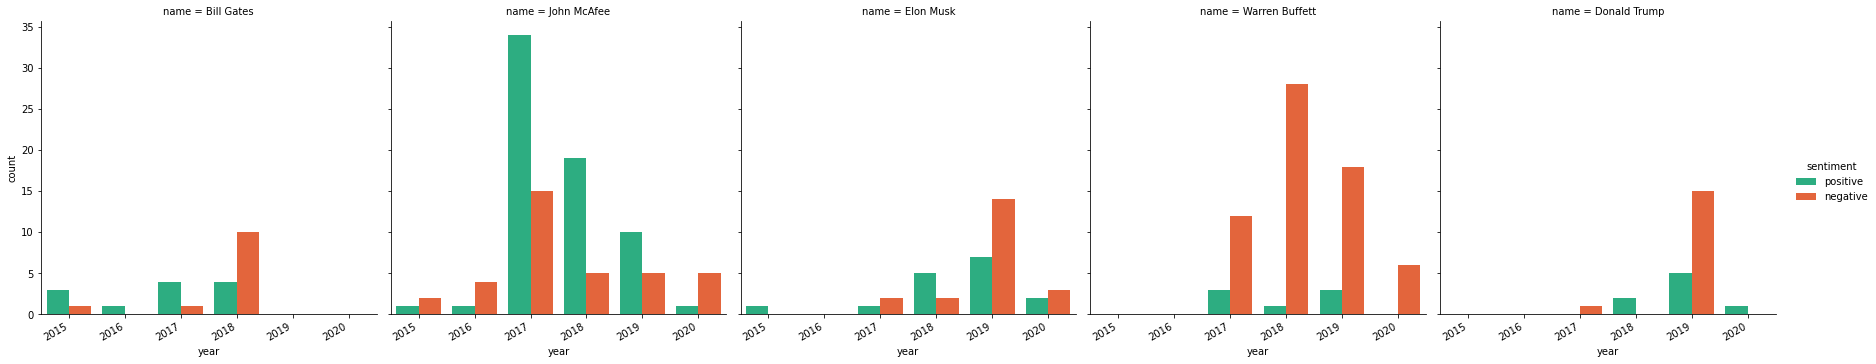

In [33]:
# Get the quotations of well-known speakers
temp_df = cleaned_quotes[cleaned_quotes['qids'].isin(hand_pick_speakers)]

# Get their names
temp_df['name'] = temp_df['qids'].apply(lambda x: names[hand_pick_speakers.index(x)])
g = sns.catplot(x="year", hue='sentiment', col="name", col_wrap=5,
                data=temp_df,
                kind="count", palette=sns.color_palette(['#18C288','#FF5720']))
g.set_xticklabels(rotation=30,ha = 'right')

for i, qid in enumerate(hand_pick_speakers):
    print(speakers.loc[qid]['label'])
    for year in np.array(range(2016,2021)):
        print("\t",year)
        # Get the quotations of this speaker in this year
        speaker_by_year = cleaned_quotes[(cleaned_quotes.year==str(year))&(cleaned_quotes.qids==qid)]
        
        # Get the 5 most confident quotation
        speaker_by_year['abs_score']=speaker_by_year['score'].apply(abs)
        speaker_by_year = speaker_by_year.nlargest(5,['abs_score'])
        for i in range(len(speaker_by_year)):
            print("\t\t - ", speaker_by_year['score'].iloc[i], speaker_by_year['quotation'].iloc[i])
    print("="*10)

And then, we also handpick the most interesting fields and select people who spoke the spoke in these fields. <br> 
We plot the sentiment distribution by field by speaker over years below.

Government
	- John McAfee ['engineer', 'computer scientist', 'businessperson', 'politician', 'programmer']
	- Steven Mnuchin ['film producer', 'politician', 'banker']
	- Mark Cuban ['voice actor', 'blogger', 'venture capitalist', 'entrepreneur', "children's writer", 'film producer', 'businessperson', 'politician', 'film actor', 'financier', 'television producer']
	- Janet Yellen ['economist', 'politician', 'banker', 'professor']
	- Mario Draghi ['economist', 'university teacher', 'politician', 'banker']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


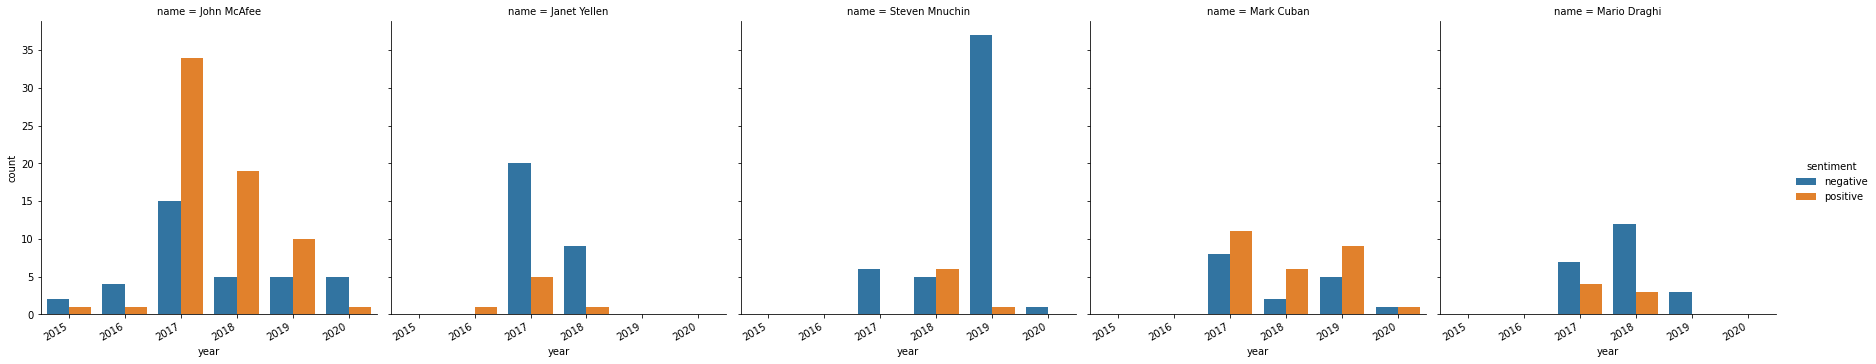

John McAfee
	 2016
		 -  -0.7497016151573916 blockchain, not Bitcoin,
		 -  -0.6631339111881971 There are tremendous technology problems with bitcoin,
		 -  -0.5868371628002933 It is number one, too complex for the average individual. The blockchain mining of coins is becoming increasingly expensive... We can talk forever about the intricate technical problems or lack of such. But from my personal opinion, I do not think the electronic currency will be Bitcoin. I'm close friends with Ron Pierce, he's one of the biggest enthusiasts of Bitcoin. Honestly, in private conversations with Ron, we get the same thing. There will be an electronic currency, that I promise you. And if it's Bitcoin, great. I just don't think it will be.
		 -  -0.3663344166443494 Here's the problem with Bitcoin; it's just like any emerging technology. The technology here isn't Bitcoin, it's digital currency. And with any emerging technology, the first few attempts are gon na have some problems. Now, you cannot deny 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	- Jamie Dimon ['banker']
	- Roger Ver ['entrepreneur']
	- Timothy C. Draper ['businessperson']
	- Jack Dorsey ['blogger', 'entrepreneur', 'chief executive officer', 'computer scientist', 'businessperson', 'programmer']
	- John McAfee ['engineer', 'computer scientist', 'businessperson', 'politician', 'programmer']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


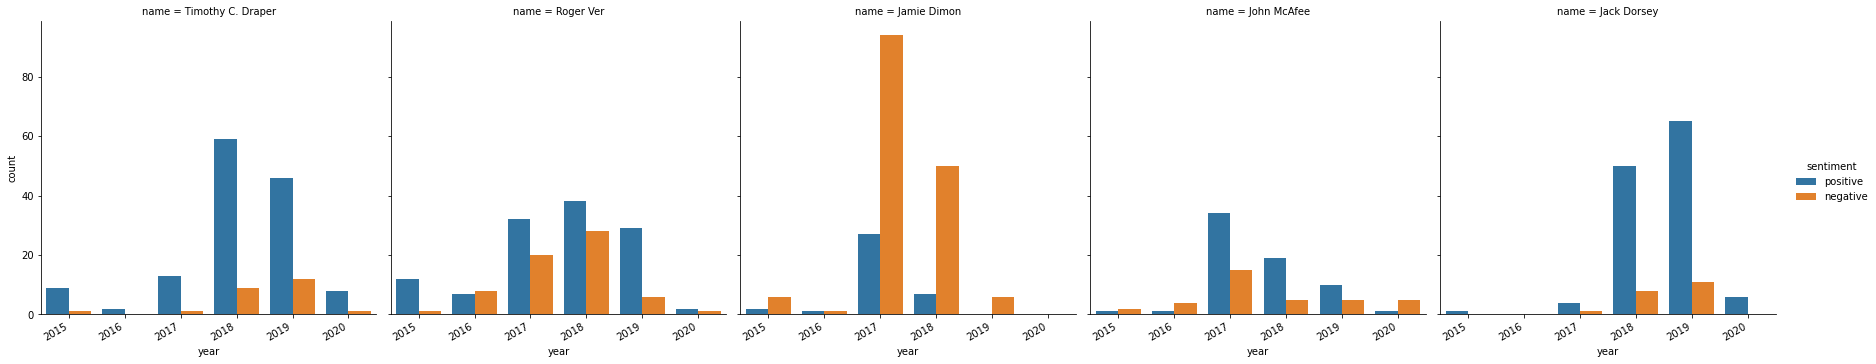

Jamie Dimon
	 2016
		 -  -0.7620970037278312 Bitcoin, the currency, I think is going to go nowhere... The blockchain is a technology which we've been studying, and yes, it's real.
		 -  0.1968646355171586 Well, Mr Dimon, you' re right. But it' s not just Silicon Valley. Technology is being developed in places like Boston, Israel, and Singapore that are threatening Wall Street' s grip on global finance. Leading that charge is Bitcoin and Blockchain. Big banks like JP Morgan have had a `monopoly on money' for far too long, and for the first time ever, that's changing,
	 2017
		 -  -0.8482337156146968 I wouldn't put this high on the category of important things in the world, but I'm not going to talk about bitcoin anymore.
		 -  -0.8457103649507189 I wouldn't put this high in the category of important things in the world, but I'm not going to talk about bitcoin anymore.
		 -  -0.8427782866874622 It's [ bitcoin ] worse than tulip bulbs. It won't end well. Someone is going to get killed. Cu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	- Jim Cramer ['radio personality', 'lawyer', 'businessperson', 'journalist', 'stockbroker', 'financier', 'actor']
	- Lloyd Blankfein ['lawyer', 'banker']
	- Arun Jaitley ['politician', 'lawyer', 'spokesperson', 'strategist']
	- Charlie Munger ['investor', 'lawyer', 'financier']
	- Nick Szabo ['computer scientist', 'jurist', 'cryptographer']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


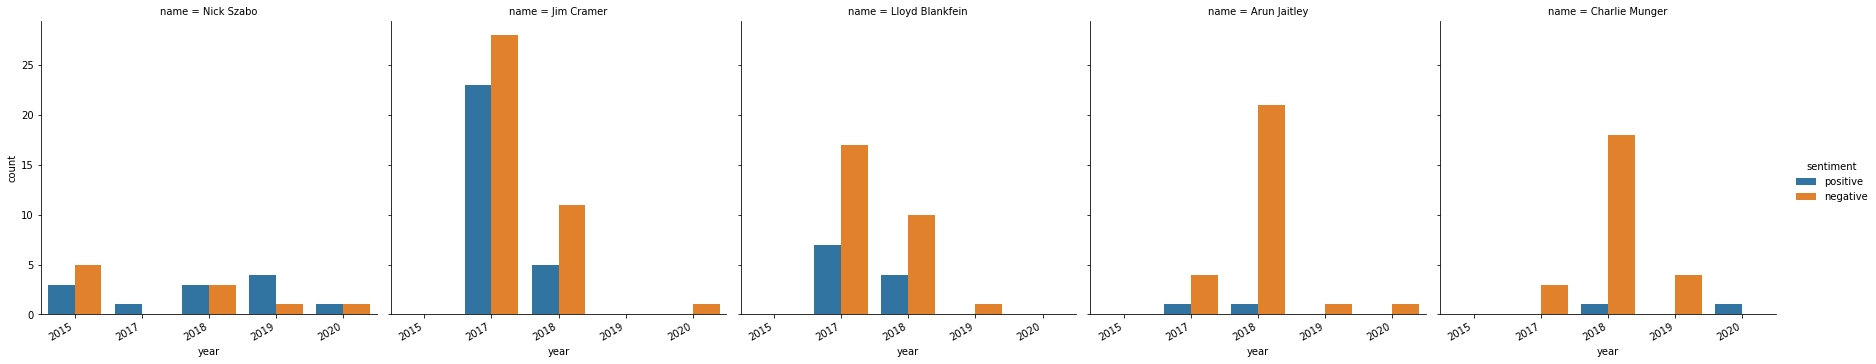

Jim Cramer
	 2016
	 2017
		 -  -0.8333133558480768 It is the anti-bitcoin,
		 -  -0.6008238103531767 This stock can't catch a break. Nothing matters. Allergan is the anti-Bitcoin.
		 -  0.5162061616731535 This is a very big victory for bitcoin last night,
		 -  0.5125364077175618 If you're a hacker and you want to be paid for a ransomware, you do it with bitcoin,
		 -  -0.4879934756945658 A year ago, one bitcoin was worth $750. You mean to tell me that's not a bubble? You think that's a safe place, a reasonable approximation of value versus the stock market?
	 2018
		 -  -0.7926948865606391 I think the tide has turned against it (Bitcoin)...,
		 -  0.5281716829340439 Bitcoin is a repository of wealth for people who don't trust anything else,
		 -  -0.451561515659705 Now Boeing is the best performing stock in the last two years, and they laugh at me. Meanwhile, Boeing has doubled. I don' t think Bitcoin is going to double from here. I just don' t!
		 -  -0.4173246655118419 Straight down

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
field_to_top_speakers = {}
for field in ['Government', 'Business, management and administration', 'Law and public policy']:    
    print(field)
    # Count number of quotations of each speaker 
    qid_to_score_and_freq = cleaned_quotes.groupby('qids',as_index=False).agg({"score":"mean","quotation":"count", "year":pd.Series.nunique})
    
    # Merge to get speaker information
    speaker_to_score_and_freq = qid_to_score_and_freq.merge(speakers, left_on='qids', right_index=True).dropna(subset=['fields'])
    
    # Keep speakers in this field only
    speaker_to_score_and_freq = speaker_to_score_and_freq[speaker_to_score_and_freq['fields'].apply(lambda x : field in x)]
    
    # Get top 5 speakers
    top_speakers = speaker_to_score_and_freq.nlargest(5,['quotation'])
    field_to_top_speakers[field] = top_speakers['qids'].tolist()
    
    # Do the same thing as well-known speakers
    for i in field_to_top_speakers[field]:
        print("\t-",speakers.loc[i]['label'], speakers.loc[i]['occupations'])
        
    temp_df = cleaned_quotes[cleaned_quotes['qids'].isin(field_to_top_speakers[field])]
    temp_df['name'] = temp_df['qids'].apply(lambda x: speakers.loc[x]['label'])
    g = sns.catplot(x="year", hue='sentiment', col="name", col_wrap=5,
                    data=temp_df,
                    kind="count")
    g.set_xticklabels(rotation=30,ha = 'right')
    plt.show()
    for i, qid in enumerate(field_to_top_speakers[field]):
        print(speakers.loc[qid]['label'])
        for year in years:
            print("\t",year)
            speaker_by_year = cleaned_quotes[(cleaned_quotes.year==str(year))&(cleaned_quotes.qids==qid)]
            speaker_by_year['abs_score']=speaker_by_year['score'].apply(abs)
            speaker_by_year = speaker_by_year.nlargest(5,['abs_score'])
            for i in range(len(speaker_by_year)):
                print("\t\t - ", speaker_by_year['score'].iloc[i], speaker_by_year['quotation'].iloc[i])
        print("="*10)

In [35]:
def query(field, year, score_filter_func):
    """
        field: string, see SELECTED_FIELDS
        year: int, string
        score_filter_func: a function taking a float number as input, used to filter to score
    """
    filtered_cleaned_quotes = cleaned_quotes[(cleaned_quotes['year']==str(year))&(cleaned_quotes['score'].apply(score_filter_func))]
    filtered_speaker_quotes = filtered_cleaned_quotes.merge(speakers, left_on='qids', right_index=True).dropna(subset=['fields'])
    filtered_speaker_quotes = filtered_speaker_quotes[filtered_speaker_quotes['fields'].apply(lambda x : field in x)]
    for i in range(len(filtered_speaker_quotes)):
        print(filtered_speaker_quotes.label.values[i], filtered_speaker_quotes.fields.values[i], filtered_speaker_quotes.quotation.values[i], filtered_speaker_quotes.score.values[i])


In [36]:
query("Sport", 2016, lambda x: x>0.5)

Joe Lee ['Sport'] Bitcoin is an uncorrelated asset class and a valuable hedging mechanism, 0.6021574487012913
John Riggins ['Sport'] This bitcoin price momentum has shown that bitcoin, the original blockchain use case, is still alive and well and that China can continue to be the driver in terms of adoption and price movement, 0.5761472089420749
Antanas Guoga ['Government', 'Sport'] I'm sure a lot of us politicians haven't got any bitcoins at the moment and we're trying to make laws for something we don't understand. I would suggest everyone to get some bitcoins and really learn about the system. It's a huge leap forward and a huge opportunity. 0.5153664378606209
Alejandro Colorado ['Sport'] I think the constant devaluations of our national currency have been building a provable evidence of how smart of an investment is it to get into Bitcoin right away, 0.5664290931890719
Joe Rogan ['Sport', 'Arts, culture and entertainment', 'Business, management and administration'] I'm all in, I'm 